https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a
https://tfhub.dev/google/nnlm-en-dim128/1
https://tfhub.dev/google/universal-sentence-encoder/2
https://blog.feedly.com/transfer-learning-in-nlp/
https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa


### Deep Transfer Learning for NLP

### Yelp Dataset- Text Classification with Universal Embeddings:

Inspite of being highly unstructured, Textual data can be classified into two major types of documents. 
    1. Factual documents : This type of documents depict some form of statements or facts with no specific feelings and emotion on it. These are also known as objective documents. 
    2. Subjective documents: This type of documents have feelings, emotions, sarcasm, prodigy and more. Sentiment analysis is mostly done in this type of datasets.
    
In this Problem, I will be looking to build supervised sentiment analysis classification models using 5000 reviews classified into positive, neutral and negative sentiment. Data Set is attached along this repository.


Word and sentence embeddings have become an essential part of any Deep-Learning-based natural language processing systems.

They encode words and sentences 📜 in fixed-length dense vectors 📐 to drastically improve the processing of textual data.

A huge trend is the quest for Universal Embeddings: embeddings that are pre-trained on a large corpus and can be plugged in a variety of downstream task models (sentimental analysis, classification, translation…) to automatically improve their performance by incorporating some general word/sentence representations learned on the larger dataset.

In [33]:
import tensorflow as tf
import tensorflow_hub as hub

In [34]:
## Import libraries and functions
import torch 
import torch.nn as nn
import torch.utils.data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns 
import re
import time
import random

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences


In [35]:
lines = []
num_totals = 2500
import json
with open ('D:/PhD_IT/data_set/yelp_academic_dataset_review.json') as f:
    for line in f:
        if (len(lines) >= (num_totals*2)):
            break
        lines.append(json.loads(line))

In [36]:
texts = [review['text'] for review in lines]
stars = [review['stars'] for review in lines]
dates = [review['date'] for review in lines]
review_id = [review['review_id'] for review in lines]
types = [review['type'] for review in lines]

In [37]:
len(texts)

5000

In [38]:
df = pd.DataFrame(dates, columns=['Dates'])
df['Review_id'] = pd.DataFrame(review_id)
df['Review'] = pd.DataFrame(texts)
df['Stars']= pd.DataFrame(stars)

In [39]:
df.head()

,Dates,Review_id,Review,Stars
0,2007-05-17,15SdjuK7DmYqUAj6rjGowg,dr. goldberg offers everything i look for in a...,5
1,2010-03-22,RF6UnRTtG7tWMcrO2GEoAg,"Unfortunately, the frustration of being Dr. Go...",2
2,2012-02-14,-TsVN230RCkLYKBeLsuz7A,Dr. Goldberg has been my doctor for years and ...,4
3,2012-03-02,dNocEAyUucjT371NNND41Q,Been going to Dr. Goldberg for over 10 years. ...,4
4,2012-05-15,ebcN2aqmNUuYNoyvQErgnA,Got a letter in the mail last week that said D...,4


Text(0.5, 0, 'Stars acquired')

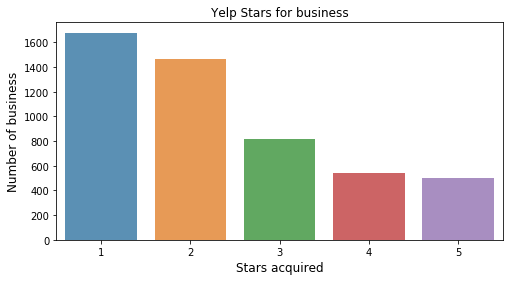

In [40]:
x = df['Stars'].value_counts()
y = x.sort_index()
plt.figure(figsize=(8,4))
ax =sns.barplot(y.index, x.values, alpha=0.8)
plt.title("Yelp Stars for business")
plt.ylabel('Number of business', fontsize =12)
plt.xlabel('Stars acquired',fontsize=12)

In [42]:
#df['labels']=df['Stars'].apply(lambda x: -1 if x <3 else (0 if x==3 else 1))  
df['labels']=df['Stars'].apply(lambda x: 0 if x <3 else 1)

In [43]:
df.head()

,Dates,Review_id,Review,Stars,labels
0,2007-05-17,15SdjuK7DmYqUAj6rjGowg,dr. goldberg offers everything i look for in a...,5,1
1,2010-03-22,RF6UnRTtG7tWMcrO2GEoAg,"Unfortunately, the frustration of being Dr. Go...",2,0
2,2012-02-14,-TsVN230RCkLYKBeLsuz7A,Dr. Goldberg has been my doctor for years and ...,4,1
3,2012-03-02,dNocEAyUucjT371NNND41Q,Been going to Dr. Goldberg for over 10 years. ...,4,1
4,2012-05-15,ebcN2aqmNUuYNoyvQErgnA,Got a letter in the mail last week that said D...,4,1


In [44]:
import re
def clean_corpus(nlp):
    words = nlp.lower()
    mytext = re.sub(r'[^a-zA-Z0-9\']', ' ', words)
    mytext = re.sub(r' +', ' ', mytext)
    return mytext.strip()

In [45]:
df['review_clean'] = df.Review.apply(clean_corpus)

In [46]:
#Drop redundant columns
review_df = df.drop(['Stars'], axis =1)
review_df = review_df.drop(['Review'], axis =1)
review_df = review_df.drop(['Dates'], axis =1)

In [47]:
review_df.head()

,Review_id,labels,review_clean
0,15SdjuK7DmYqUAj6rjGowg,1,dr goldberg offers everything i look for in a ...
1,RF6UnRTtG7tWMcrO2GEoAg,0,unfortunately the frustration of being dr gold...
2,-TsVN230RCkLYKBeLsuz7A,1,dr goldberg has been my doctor for years and i...
3,dNocEAyUucjT371NNND41Q,1,been going to dr goldberg for over 10 years i ...
4,ebcN2aqmNUuYNoyvQErgnA,1,got a letter in the mail last week that said d...


In [48]:
reviews = review_df['review_clean'].values
sentiments = review_df['labels'].values
print (len(reviews))
train_reviews = reviews[:4000]
train_sentiments = sentiments[:4000]

val_reviews = reviews[4000:5000]
val_sentiments = sentiments[4000:5000]

test_reviews = reviews[4000:]
test_sentiments = sentiments[4000:]
train_reviews.shape, val_reviews.shape, test_reviews.shape

5000


((4000,), (1000,), (1000,))

In [49]:
#Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments, 
    batch_size=256, num_epochs=None, shuffle=True)

In [50]:

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': train_reviews}, train_sentiments, shuffle=False)

In [51]:
# Prediction on the whole validation set.
predict_val_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': val_reviews}, val_sentiments, shuffle=False)

In [52]:
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': test_reviews}, test_sentiments, shuffle=False)

In [53]:
embedding_feature = hub.text_embedding_column(
    key='sentence', 
    module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
    trainable=False)

In [54]:
dnn = tf.estimator.DNNClassifier(
          hidden_units=[512, 128],
          feature_columns=[embedding_feature],
          n_classes=2,
          activation_fn=tf.nn.relu,
          dropout=0.1,
          optimizer=tf.train.AdagradOptimizer(learning_rate=0.005))

In [ ]:
tf.logging.set_verbosity(tf.logging.ERROR)
import time

TOTAL_STEPS = 1500
STEP_SIZE = 500
for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step =', step)
    start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed_time = time.time() - start_time
    print('Train Time (s):', elapsed_time)
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
    print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))

In [56]:
#Model Evaluation:
dnn.evaluate(input_fn=predict_train_input_fn)

{'accuracy': 0.98675,
 'accuracy_baseline': 0.80375,
 'auc': 0.99859035,
 'auc_precision_recall': 0.99963844,
 'average_loss': 0.05726607,
 'label/mean': 0.80375,
 'loss': 7.158259,
 'precision': 0.98796296,
 'prediction/mean': 0.80898315,
 'recall': 0.9956454,
 'global_step': 1100}

In [57]:
dnn.evaluate(input_fn=predict_test_input_fn)

{'accuracy': 0.864,
 'accuracy_baseline': 0.744,
 'auc': 0.91317,
 'auc_precision_recall': 0.9680733,
 'average_loss': 0.36329368,
 'label/mean': 0.744,
 'loss': 45.41171,
 'precision': 0.9010554,
 'prediction/mean': 0.7449443,
 'recall': 0.9180108,
 'global_step': 1100}

### Build a Generic Model Trainer on any input Sentence Encoder

In [58]:
import time

TOTAL_STEPS = 1000
STEP_SIZE = 500

my_checkpointing_config = tf.estimator.RunConfig(
    keep_checkpoint_max = 2,       # Retain the 2 most recent checkpoints.
)

def train_and_evaluate_with_sentence_encoder(hub_module, train_module=False, path=''):
    embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec=hub_module, trainable=train_module)
  
    print()
    print('='*100)
    print('Training with', hub_module)
    print('Trainable is:', train_module)
    print('='*100)
  
    dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
            model_dir=path,
            config=my_checkpointing_config)

    for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
        print('-'*100)
        print('Training for step =', step)
        start_time = time.time()
        dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
        elapsed_time = time.time() - start_time
        print('Train Time (s):', elapsed_time)
        print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
        print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))

    train_eval_result = dnn.evaluate(input_fn=predict_train_input_fn)
    test_eval_result = dnn.evaluate(input_fn=predict_test_input_fn)

    return {
      "Model Dir": dnn.model_dir,
      "Training Accuracy": train_eval_result["accuracy"],
      "Test Accuracy": test_eval_result["accuracy"],
      "Training AUC": train_eval_result["auc"],
      "Test AUC": test_eval_result["auc"],
      "Training Precision": train_eval_result["precision"],
      "Test Precision": test_eval_result["precision"],
      "Training Recall": train_eval_result["recall"],
      "Test Recall": test_eval_result["recall"]
    }


### Train Deep Learning Models on difference Sentence Encoders

In [ ]:
tf.logging.set_verbosity(tf.logging.ERROR)

results = {}

results["nnlm-en-dim128"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", path='/storage/models/nnlm-en-dim128_f/')

results["nnlm-en-dim128-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", train_module=True, path='/storage/models/nnlm-en-dim128_t/')

results["use-512"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", path='/storage/models/use-512_f/')

results["use-512-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", train_module=True, path='/storage/models/use-512_t/')


Training with https://tfhub.dev/google/nnlm-en-dim128/1
Trainable is: False
----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 27.536242723464966
Eval Metrics (Train): {'accuracy': 0.90375, 'accuracy_baseline': 0.80375, 'auc': 0.942377, 'auc_precision_recall': 0.9843997, 'average_loss': 0.23683174, 'label/mean': 0.80375, 'loss': 29.603968, 'precision': 0.9298299, 'prediction/mean': 0.7819461, 'recall': 0.95209956, 'global_step': 500}
Eval Metrics (Validation): {'accuracy': 0.834, 'accuracy_baseline': 0.744, 'auc': 0.8845609, 'auc_precision_recall': 0.95143014, 'average_loss': 0.36361328, 'label/mean': 0.744, 'loss': 45.45166, 'precision': 0.8822751, 'prediction/mean': 0.7220158, 'recall': 0.89650536, 'global_step': 500}
----------------------------------------------------------------------------------------------------
Training for step = 500
Train Time (s): 27.30005979537964
Eval Metrics (Train): 

### Model Evaluations:

In [ ]:
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

In [ ]:
best_model_dir = results_df[results_df['Test Accuracy'] == results_df['Test Accuracy'].max()]['Model Dir'].values[0]
best_model_dir

In [ ]:
embedding_feature = hub.text_embedding_column(
        key='sentence', module_spec="https://tfhub.dev/google/universal-sentence-encoder/2", trainable=True)

dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
            model_dir=best_model_dir)
dnn

In [ ]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

In [ ]:
predictions = get_predictions(estimator=dnn, input_fn=predict_test_input_fn)
predictions[:10]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.Session() as session:
    cm = tf.confusion_matrix(test_sentiments, predictions).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_sentiments, y_pred=predictions, target_names=LABELS))